In [1]:
import sys
sys.path.append('../')

from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
from peft_pretraining.relora import ReLoRaModel

/mnt/shared_home/vlialin/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ls ../checkpoints/llama_130m-2023-05-09-19-17-11

model_10000


In [2]:
# llama_130m-2023-05-09-19-18-46 is major-moon-154
# https://wandb.ai/guitaricet/peft_pretraining/runs/508253bk
regular_250M = AutoModelForCausalLM.from_pretrained("../checkpoints/llama_130m-2023-05-09-19-18-46")

# https://wandb.ai/guitaricet/peft_pretraining/runs/ssd29pp9
peft_250M = ReLoRaModel.from_pretrained("../checkpoints/llama_130m-2023-05-09-19-17-11/model_10000")

llama_7b = AutoModelForCausalLM.from_pretrained("huggyllama/llama-7b")

keep_original: False


Loading checkpoint shards: 100%|██████████| 2/2 [00:18<00:00,  9.32s/it]


In [3]:
import torch
from tqdm import tqdm

# get singular values of all layers
q_projs = []
k_projs = []
v_projs = []
o_projs = []
gate_projs = []
down_projs = []
up_projs = []

for layer in tqdm(regular_250M.model.layers):
    q_projs_weight = layer.self_attn.q_proj.weight.detach()
    singular_values = torch.svd(q_projs_weight).S
    q_projs.append(singular_values)

    k_projs_weight = layer.self_attn.k_proj.weight.detach()
    singular_values = torch.svd(k_projs_weight).S
    k_projs.append(singular_values)

    v_projs_weight = layer.self_attn.v_proj.weight.detach()
    singular_values = torch.svd(v_projs_weight).S
    v_projs.append(singular_values)

    o_projs_weight = layer.self_attn.o_proj.weight.detach()
    singular_values = torch.svd(o_projs_weight).S
    o_projs.append(singular_values)

    gate_projs_weight = layer.mlp.gate_proj.weight.detach()
    singular_values = torch.svd(gate_projs_weight).S
    gate_projs.append(singular_values)

    down_projs_weight = layer.mlp.down_proj.weight.detach()
    singular_values = torch.svd(down_projs_weight).S
    down_projs.append(singular_values)

    up_projs_weight = layer.mlp.up_proj.weight.detach()
    singular_values = torch.svd(up_projs_weight).S
    up_projs.append(singular_values)

100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


In [10]:
import torch
from tqdm import tqdm

def get_linear_weight_from_relora(relora_layer):
    return relora_layer.lora_B.weight @ relora_layer.lora_A.weight * relora_layer.scaling

# get singular values of all layers
peft_q_projs = []
peft_k_projs = []
peft_v_projs = []
peft_o_projs = []
peft_gate_projs = []
peft_down_projs = []
peft_up_projs = []

for layer in tqdm(peft_250M.wrapped_model.model.layers):
    q_projs_weight = get_linear_weight_from_relora(layer.self_attn.q_proj).detach()
    singular_values = torch.svd(q_projs_weight).S
    peft_q_projs.append(singular_values)

    k_projs_weight = get_linear_weight_from_relora(layer.self_attn.k_proj).detach()
    singular_values = torch.svd(k_projs_weight).S
    peft_k_projs.append(singular_values)

    v_projs_weight = get_linear_weight_from_relora(layer.self_attn.v_proj).detach()
    singular_values = torch.svd(v_projs_weight).S
    peft_v_projs.append(singular_values)

    o_projs_weight = get_linear_weight_from_relora(layer.self_attn.o_proj).detach()
    singular_values = torch.svd(o_projs_weight).S
    peft_o_projs.append(singular_values)

    gate_projs_weight = get_linear_weight_from_relora(layer.mlp.gate_proj).detach()
    singular_values = torch.svd(gate_projs_weight).S
    peft_gate_projs.append(singular_values)

    down_projs_weight = get_linear_weight_from_relora(layer.mlp.down_proj).detach()
    singular_values = torch.svd(down_projs_weight).S
    peft_down_projs.append(singular_values)

    up_projs_weight = get_linear_weight_from_relora(layer.mlp.up_proj).detach()
    singular_values = torch.svd(up_projs_weight).S
    peft_up_projs.append(singular_values)

100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


In [86]:
import torch
from tqdm import tqdm

# get singular values of all layers
# noised_peft_q_projs = []
noised_peft_q_projs = []
noised_peft_down_projs = []

for layer in tqdm(peft_250M.wrapped_model.model.layers):
    q_projs_weight = get_linear_weight_from_relora(layer.self_attn.q_proj).detach() + torch.randn_like(get_linear_weight_from_relora(layer.self_attn.q_proj).detach()) * 0.04
    singular_values = torch.svd(q_projs_weight).S
    noised_peft_q_projs.append(singular_values)

    # down proj
    down_projs_weight = get_linear_weight_from_relora(layer.mlp.down_proj).detach() + torch.randn_like(get_linear_weight_from_relora(layer.mlp.down_proj).detach()) * 0.04
    singular_values = torch.svd(down_projs_weight).S
    noised_peft_down_projs.append(singular_values)


100%|██████████| 12/12 [00:04<00:00,  2.82it/s]


In [26]:
# perform magtinude pruning
import numpy as np

import torch
from tqdm import tqdm

pruned_peft_q_projs = []

for layer in tqdm(peft_250M.wrapped_model.model.layers):
    q_projs_weight = get_linear_weight_from_relora(layer.self_attn.q_proj).detach()

    threshold_90p = np.percentile(q_projs_weight.abs().numpy(), 0.01)
    q_projs_weight = q_projs_weight * (q_projs_weight.abs() > threshold_90p)
    singular_values = torch.svd(q_projs_weight).S
    pruned_peft_q_projs.append(singular_values)

# for regular

pruned_q_projs = []

for layer in tqdm(regular_250M.model.layers):
    q_projs_weight = layer.self_attn.q_proj.weight.detach()

    threshold_90p = np.percentile(q_projs_weight.abs(), 0.01)
    q_projs_weight = q_projs_weight * (q_projs_weight.abs() > threshold_90p)
    # q_projs_weight = torch.zeros_like(q_projs_weight)
    singular_values = torch.svd(q_projs_weight).S
    pruned_q_projs.append(singular_values)

# random pruning of regular

random_pruned_q_projs = []

for layer in tqdm(regular_250M.model.layers):
    q_projs_weight = layer.self_attn.q_proj.weight.detach()

    threshold_90p = np.percentile(q_projs_weight.abs(), 0.01)
    q_projs_weight = q_projs_weight * (torch.rand_like(q_projs_weight) > threshold_90p)
    singular_values = torch.svd(q_projs_weight).S
    random_pruned_q_projs.append(singular_values)


100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


In [22]:
# prune down projection

pruned_down_projs = []

for layer in tqdm(regular_250M.model.layers):
    down_projs_weight = layer.mlp.down_proj.weight.detach()

    threshold_90p = np.percentile(down_projs_weight.abs(), 0.01)
    down_projs_weight = down_projs_weight * (down_projs_weight.abs() > threshold_90p)
    singular_values = torch.svd(down_projs_weight).S
    pruned_down_projs.append(singular_values)


100%|██████████| 12/12 [00:02<00:00,  4.01it/s]


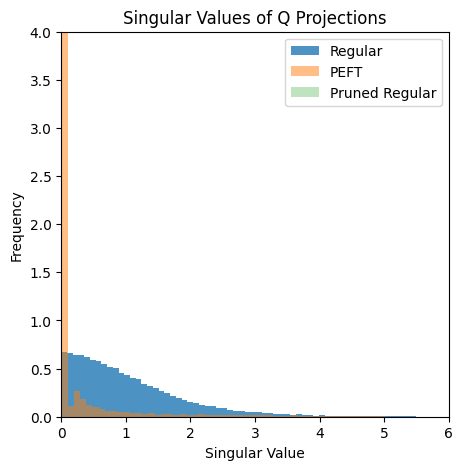

In [27]:
# plot histogram of singular values for q_projs over layers
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.set_title("Singular Values of Q Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
# ax.hist(torch.cat(noised_peft_q_projs).numpy(), density=True, bins=100, alpha=0.3, label="Noised PEFT")
ax.hist(torch.cat(q_projs).numpy(), density=True, bins=100, alpha=0.8, label="Regular")
ax.hist(torch.cat(peft_q_projs).numpy(), density=True, bins=100, alpha=0.5, label="PEFT")
# ax.hist(torch.cat(pruned_peft_q_projs).numpy(), density=True, bins=100, alpha=0.3, label="Pruned PEFT")
ax.hist(torch.cat(pruned_q_projs).numpy(), density=True, bins=100, alpha=0.3, label="Pruned Regular")
# ax.hist(torch.cat(random_pruned_q_projs).numpy(), density=True, bins=100, alpha=0.3, label="Random Pruned Regular")

# ylim
ax.set_ylim(0, 4)
ax.set_xlim(0, 6)

ax.legend()
plt.show()

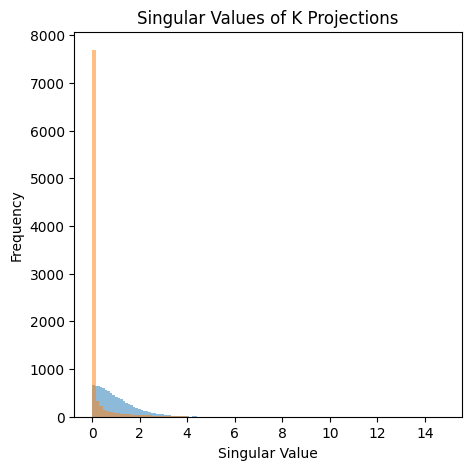

In [6]:
# plot histogram of singular values for k_projs over layers
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.set_title("Singular Values of K Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
ax.hist(torch.cat(k_projs).numpy(), bins=100, alpha=0.5, label="Regular")
ax.hist(torch.cat(peft_k_projs).numpy(), bins=100, alpha=0.5, label="PEFT")
ax.hist(torch.cat(llama7b_k_projs).numpy(), bins=100, alpha=0.5, label="LLAMA-7B")
plt.show()

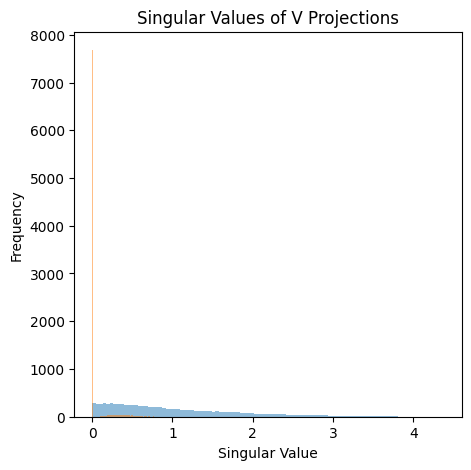

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Singular Values of V Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
ax.hist(torch.cat(v_projs).numpy(), bins=100, alpha=0.5, label="Regular")
ax.hist(torch.cat(peft_v_projs).numpy(), bins=100, alpha=0.5, label="PEFT")
ax.hist(torch.cat(llama7b_v_projs).numpy(), bins=100, alpha=0.5, label="LLAMA-7B")
plt.show()

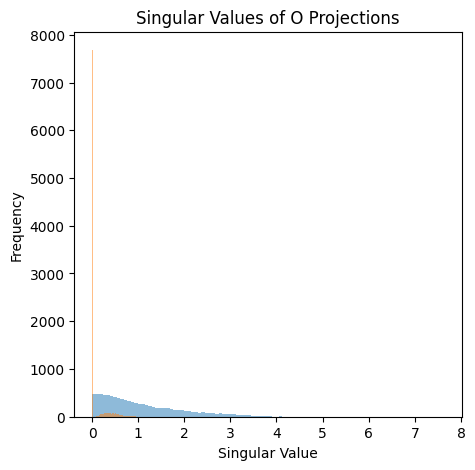

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Singular Values of O Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
ax.hist(torch.cat(o_projs).numpy(), bins=100, alpha=0.5, label="Regular")
ax.hist(torch.cat(peft_o_projs).numpy(), bins=100, alpha=0.5, label="PEFT")
plt.show()

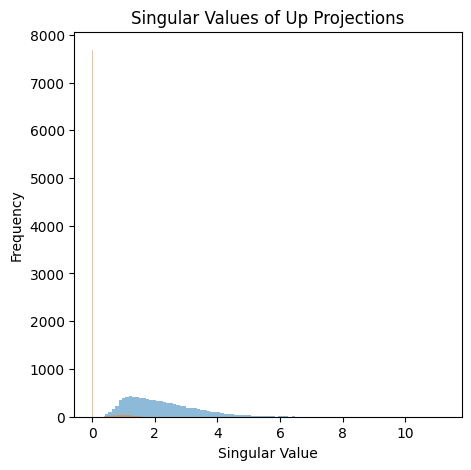

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Singular Values of Up Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
ax.hist(torch.cat(up_projs).numpy(), bins=100, alpha=0.5, label="Regular")
ax.hist(torch.cat(peft_up_projs).numpy(), bins=100, alpha=0.5, label="PEFT")
plt.show()

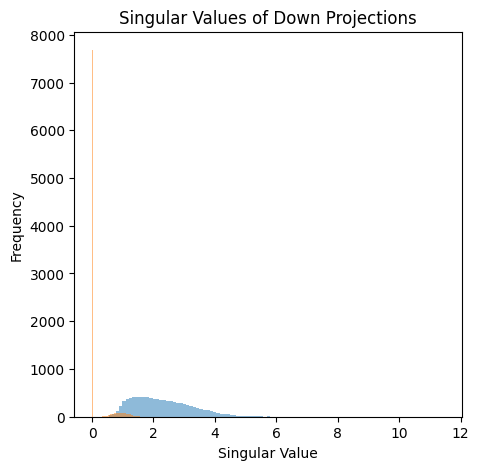

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Singular Values of Down Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
ax.hist(torch.cat(down_projs).numpy(), bins=100, alpha=0.5, label="Regular")
ax.hist(torch.cat(peft_down_projs).numpy(), bins=100, alpha=0.5, label="PEFT")
plt.show()

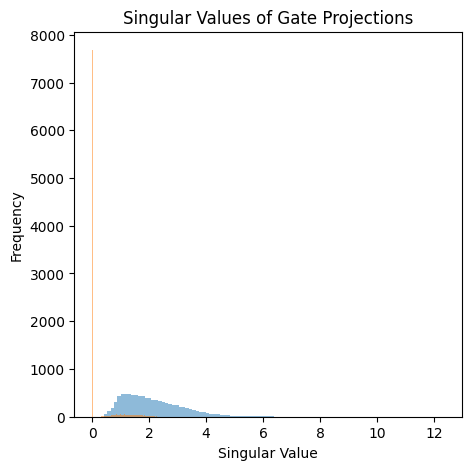

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Singular Values of Gate Projections")
ax.set_xlabel("Singular Value")
ax.set_ylabel("Frequency")
ax.hist(torch.cat(gate_projs).numpy(), bins=100, alpha=0.5, label="Regular")
ax.hist(torch.cat(peft_gate_projs).numpy(), bins=100, alpha=0.5, label="PEFT")
plt.show()